In [1]:
import pandas as pd
import numpy as np
import datetime
import pmdarima as pm
from statsmodels.tsa.stattools import adfuller
from numpy import log
from time import time
import statsmodels.api as sm
from statsmodels.tsa.api import VAR
from statsmodels.tsa.base.datetools import dates_from_str
from statsmodels.tsa.vector_ar import plotting
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.gofplots import qqplot
from pandas.plotting import autocorrelation_plot
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

In [2]:
from statsmodels.tsa.stattools import grangercausalitytests
maxlag=4
test = 'ssr_chi2test'

def grangers_causation_matrix(data, maxlag, verbose=False):   
    
    """Check Granger Causality of all possible combinations of the Time series.
    The rows are the response variable, columns are predictors. The values in the table 
    are the P-Values. P-Values lesser than the significance level (0.05), implies 
    the Null Hypothesis that the coefficients of the corresponding past values is 
    zero, that is, the X does not cause Y can be rejected.

    data      : pandas dataframe containing the time series variables
    variables : list containing names of the time series variables.
    """
    variables = data.columns
    df = pd.DataFrame(np.zeros((len(variables), len(variables))),
                      columns=variables, index=variables)
    for c in df.columns:
        for r in df.index:
            test_result = grangercausalitytests(data[[r, c]], maxlag=maxlag, verbose=False)
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
            if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
            min_p_value = np.min(p_values)
            df.loc[r, c] = min_p_value
    df.columns = [var + '_Y' for var in variables]
    df.index = [var + '_X' for var in variables]
    
    return df

In [3]:
def auto_diff_col(df):
    for col in df.columns:
        adf = adfuller_test(df[col])
        if adf > 0.05:
            print(col,'has been differenced',adf)
            df[col] = df[col].diff(1)
            df = df[1:]
            print('new adf is ',adfuller_test(df[col]))
    return df

def adfuller_test(series, signif=0.05, name='', verbose=False):
    """Perform ADFuller to test for Stationarity of given series and print report"""
    r = adfuller(series, autolag='AIC')
    output = {'test_statistic':round(r[0], 4),
              'pvalue':round(r[1], 4), 
              'n_lags':round(r[2], 4),
              'n_obs':r[3]}
    p_value = output['pvalue']
    return p_value

In [4]:
import statsmodels.tsa.stattools as ts 

In [5]:
# find the best lag
def find_lag(data):
    model = VAR(data)
    lags=[]
    for i in [1,2,3,4,5,6,7,8,9,10]:
        try:
            result = model.fit(i)
            lags.append([result.aic,result.bic,result.fpe,result.hqic])
        except np.linalg.LinAlgError as err:
            break
        except ValueError:
            break

    find_lags = pd.DataFrame(lags)
    find_lags.columns = ['aic','bic','fpe','hqic']
    find_lags.index = find_lags.index + 1
    maxlag = find_lags.idxmin().mode().values[0]
    return maxlag

In [6]:
def make_var_model(data, lag, actual_plot = False ):
 
    # make a VAR model
    model = VAR(data)
    results = model.fit(maxlags = lag)
    lag_order = results.k_ar
    fitted_values = results.fittedvalues
    
    # step: number of future weeks
    conf = results.forecast_interval(y= data.values[-lag_order:], steps = 5,alpha=0.8)
    conf_intv = pd.concat([pd.DataFrame(conf[0])[0],
                           pd.DataFrame(conf[1])[0],
                           pd.DataFrame(conf[2])[0]],axis=1)
    conf_intv.columns=['ys','lower','upper']
    return fitted_values,conf_intv,results

In [7]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

In [8]:
# show values on plot
def note(xs,ys,posi,height,colr):  
    for x,y in zip(xs,ys):
        label = "{:.2f}".format(y)
        plt.annotate(label, # this is the text
                     (x,y), # these are the coordinates to position the label
                     textcoords="offset points", # how to position the text
                     xytext=(0,height), # distance from text to points (x,y)
                     ha=posi,va='bottom',color=colr,fontsize=10) 
        # horizontal alignment can be left, right or center
    return

In [13]:
df = pd.read_excel(r'D:\papers\writing_sample\i_s.xlsx','Sheet2')
cut = 29
dt = df[['trade_balance', 'gap_(s-i)','ExchangeRate_yuan_dollar']][cut:]

In [25]:
def fit_var(dt,lag):
    fitted,conf,results = make_var_model(data = dt,lag=lag, actual_plot = False )
    df_res = pd.concat([fitted[['trade_balance']],conf],axis=0)
    df_res['trade_balance'][-5:] = df_res['ys'][-5:]

    df_res['lower'].iloc[-6] =  df_res['trade_balance'].iloc[-6]
    df_res['upper'].iloc[-6] =  df_res['trade_balance'].iloc[-6]

    df_res['id'] = np.arange(cut+lag,96)

    match_data = dt[lag:]
    rmse = mean_squared_error(match_data['trade_balance'],fitted['trade_balance'])
    return df_res,rmse,results

In [27]:
max_lag = find_lag(dt)
print(max_lag)
ls_rmse = []
i = 1
while i < max_lag-2:
    df_res,rmse,results = fit_var(dt,i)
    ls_rmse.append(rmse)
    i+=1

9


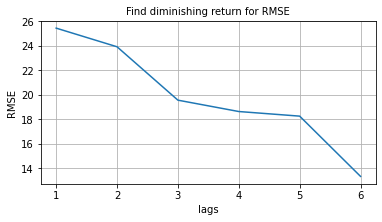

In [28]:
plt.figure(figsize=(6,3) )
plt.title('Find diminishing return for RMSE',fontsize=10) 
plt.plot(np.arange(1,max_lag-2),ls_rmse)
plt.ylabel('RMSE')
plt.xlabel('lags')
plt.grid()

In [30]:
df_res,rmse,results = fit_var(dt,3)
results.params

,trade_balance,gap_(s-i),ExchangeRate_yuan_dollar
const,0.004080,0.063445,0.206225
L1.trade_balance,0.688963,0.000339,0.007827
L1.gap_(s-i),-299.551961,0.499741,2.373233
L1.ExchangeRate_yuan_dollar,1.185153,0.003621,1.379664
L2.trade_balance,0.067442,-0.000682,-0.008049
L2.gap_(s-i),217.960658,0.121112,0.113681
L2.ExchangeRate_yuan_dollar,12.266664,-0.003149,-0.753797
L3.trade_balance,-0.101542,0.000399,-0.001495
L3.gap_(s-i),-266.606762,0.076231,-1.660730
L3.ExchangeRate_yuan_dollar,-16.595299,-0.008616,0.319934


In [31]:
def plot_var(df,df_res,lag):
    plt.figure(figsize=(14,8) )
    clr_n = 'black'
    clr_f='#ffa303'
    clr_t = '#0f3994'

    plt.subplot(211)
    plt.title('Forecasting for Trade Balance of U.S.with China (lag = %s)'%lag,fontsize=16) 
    plt.plot(dt['trade_balance'], label='True',color = clr_t,alpha = 0.7)

    plt.plot(df_res['id'], df_res['trade_balance'],label='forecast',color=clr_f)
    plt.plot(df_res['id'], df_res['lower'],ls="--",color=clr_f)
    plt.plot(df_res['id'], df_res['upper'],ls="--",color=clr_f)

    ls = np.arange(df_res['id'].values[0]-3,df_res['id'].values[-1]+2,1)
    xtick = list(df['year-quarter'][cut+lag-3:])+['2021_Q4','2022_Q1','2022_Q2','2022_Q3','2022_Q4']

    plt.axvline(91, c="tab:gray",ls="--")
    plt.xticks(ls[::4], xtick[::4], fontsize = 8, rotation = 90)
    plt.legend(loc='best')

    plt.subplot(313)
    plt.subplots_adjust(wspace =0, hspace = 0)
    dt_ = dt[-5:]
    df_res_ = df_res[-10:]
    plt.plot(dt_['trade_balance'],label='True',color = clr_t,alpha = 0.7)

    plt.plot(df_res_['id'],df_res_['trade_balance'],label='forecast',color=clr_f)
    plt.plot(df_res['id'], df_res['lower'],ls="--",color=clr_f)
    plt.plot(df_res['id'], df_res['upper'],ls="--",color=clr_f)

    note(dt_.index,dt_['trade_balance'],'left',0,clr_t)
    note(df_res_['id'][:5],df_res_['trade_balance'][:5],'right',-5,clr_n)
    note(df_res_['id'][5:],df_res_['lower'][5:],'right',-5,clr_n)
    note(df_res_['id'][5:],df_res_['upper'][5:],'right',-5,clr_n)

    plt.title('Details after Zoom Out',fontsize=10) 

    plt.axvline(91, c="tab:gray",ls="--")
    plt.xticks(ls[-11:], xtick[-11:], fontsize = 8, rotation = 90)
    plt.grid(axis='x',alpha=0.5)
    plt.legend(loc='lower right')
    plt.show()
    return 

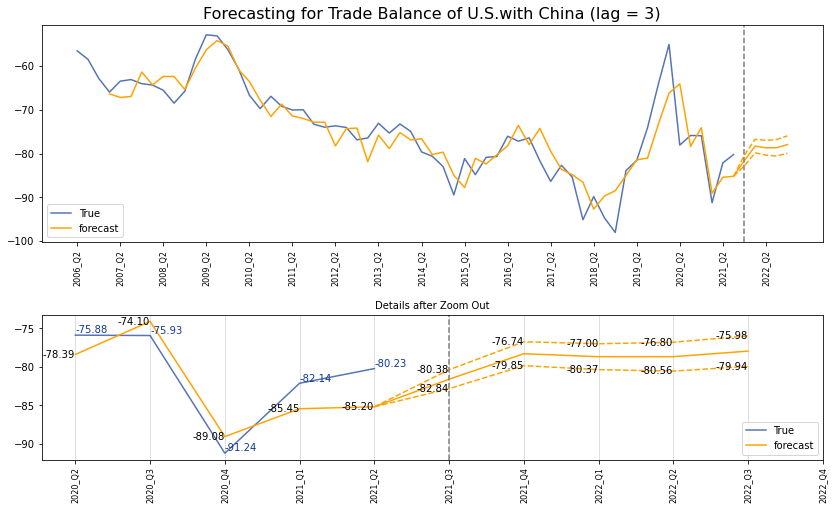

In [38]:
 plot_var(df,df_res,3)